In [1]:
from tape import datasets
from tape import TAPETokenizer
import torch
import numpy as np

In [2]:
with open('training_data_new_fasta.npy', 'rb') as f:
    training_data = np.load(f)

In [3]:
print(len(training_data))
print(training_data.shape)
print(training_data[0:21])

674550
(674550, 2)
[[ 2. 16.]
 [ 2. 23.]
 [ 2. 23.]
 [ 2. 19.]
 [ 2. 17.]
 [ 2. 17.]
 [ 2. 19.]
 [ 2. 17.]
 [ 2.  8.]
 [ 2. 28.]
 [16.  2.]
 [16. 23.]
 [16. 23.]
 [16. 19.]
 [16. 17.]
 [16. 17.]
 [16. 19.]
 [16. 17.]
 [16.  8.]
 [16. 28.]
 [16. 13.]]


In [4]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(np.array(range(30)).reshape(-1,1))
onehot_label_x = enc.transform(training_data[:,0].reshape(-1,1)).toarray()

print("onehot_label_x")
print(onehot_label_x)

enc = OneHotEncoder()
enc.fit(np.array(range(30)).reshape(-1,1))
onehot_label_y = enc.transform(training_data[:,1].reshape(-1,1)).toarray()

print("onehot_label_y")
print(onehot_label_y)

onehot_label_x
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
onehot_label_y
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
onehot_label_y[0:100000].shape

(100000, 30)

In [6]:
input_size = 30
hidden_size = 2
learning_rate = 0.01
num_epochs = 10

from torch import nn
from torchsummary  import summary

class WEMB(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WEMB, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.softmax = nn.Softmax(dim=1)

        self.l1 = nn.Linear(self.input_size, self.hidden_size, bias=False)
        self.l2 = nn.Linear(self.hidden_size, self.input_size, bias=False)

    def forward(self, x):
        out_bn = self.l1(x) # bn - bottle_neck
        out = self.l2(out_bn)
        out = self.softmax(out)
        return out, out_bn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = WEMB(input_size, hidden_size).to(device)
model.train(True)
print(model)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, \
                            momentum=0, weight_decay=0, nesterov=False)
summary(model, torch.ones((1,30)))

WEMB(
  (softmax): Softmax(dim=1)
  (l1): Linear(in_features=30, out_features=2, bias=False)
  (l2): Linear(in_features=2, out_features=30, bias=False)
)
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 2]                   60
├─Linear: 1-2                            [-1, 30]                  60
├─Softmax: 1-3                           [-1, 30]                  --
Total params: 120
Trainable params: 120
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 2]                   60
├─Linear: 1-2                            [-1, 30]                  60
├─Softmax: 1-3                           [-1, 30]                  --
Total params: 120
Trainable params: 120
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Epoch [1/10], Loss: 0.1478
Epoch [2/10], Loss: 0.1406
Epoch [3/10], Loss: 0.1203
Epoch [4/10], Loss: 0.1138
Epoch [5/10], Loss: 0.1130
Epoch [6/10], Loss: 0.1126
Epoch [7/10], Loss: 0.1122
Epoch [8/10], Loss: 0.1119
Epoch [9/10], Loss: 0.1117
Epoch [10/10], Loss: 0.1115


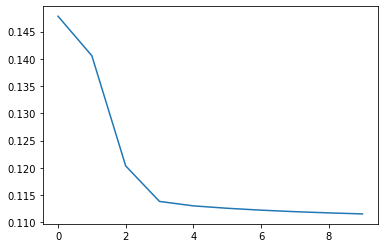

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_val = []

onehot_label_x = torch.from_numpy(onehot_label_x[0:100000]).to(device)
onehot_label_y = torch.from_numpy(onehot_label_y[0:100000]).to(device)

for epoch in range(num_epochs):
    for i in range(onehot_label_y.shape[0]):
        inputs = onehot_label_x[i].float()
        labels = onehot_label_y[i].float()
        inputs = inputs.unsqueeze(0)
        labels = labels.unsqueeze(0)

        # Forward pass
        output, wemb = model(inputs)
        loss = criterion(output, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_val.append(loss.item())

    if (epoch+1) % 1 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_val)
plt.show()

In [8]:
print("Output")
print(output.shape)
print(output)
print("Wemb")
print(wemb.shape)
print(wemb)

Output
torch.Size([1, 30])
tensor([[0.0014, 0.0014, 0.0053, 0.0058, 0.0014, 0.1067, 0.0009, 0.0184, 0.0529,
         0.0777, 0.0333, 0.0878, 0.0151, 0.0389, 0.0901, 0.0862, 0.0280, 0.0541,
         0.0014, 0.0171, 0.0482, 0.0400, 0.0441, 0.0272, 0.0009, 0.0394, 0.0167,
         0.0010, 0.0576, 0.0012]], grad_fn=<SoftmaxBackward>)
Wemb
torch.Size([1, 2])
tensor([[1.1213, 0.8005]], grad_fn=<MmBackward>)


In [9]:
m = nn.Softmax()
loss = nn.BCELoss()
input_ = torch.tensor([0.9,0.0,0.0])
target = torch.tensor([1.0,0.0,0.0])
outputOne = loss(m(input_), target)
print(input, m(input_), target) 
print("Loss",outputOne)

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x00000260E85CC3A0>> tensor([0.5515, 0.2242, 0.2242]) tensor([1., 0., 0.])
Loss tensor(0.3676)


<ipython-input-9-ba3d1cc5fecb>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputOne = loss(m(input_), target)
<ipython-input-9-ba3d1cc5fecb>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(input, m(input_), target)


In [10]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input_ = torch.tensor([0.9,0.0,0.0])
target = torch.tensor([1.0,0.0,0.0])
outputTwo = loss(m(input_), target)
print(input, m(input_), target) 
print("Loss",outputTwo)

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x00000260E85CC3A0>> tensor([0.7109, 0.5000, 0.5000]) tensor([1., 0., 0.])
Loss tensor(0.5758)


In [11]:
from typing import List
import logging
from collections import OrderedDict
import numpy as np
IUPAC_VOCAB = OrderedDict([
    ("<pad>", 0),
    ("<mask>", 1),
    ("<cls>", 2),
    ("<sep>", 3),
    ("<unk>", 4),
    ("A", 5),
    ("B", 6),
    ("C", 7),
    ("D", 8),
    ("E", 9),
    ("F", 10),
    ("G", 11),
    ("H", 12),
    ("I", 13),
    ("K", 14),
    ("L", 15),
    ("M", 16),
    ("N", 17),
    ("O", 18),
    ("P", 19),
    ("Q", 20),
    ("R", 21),
    ("S", 22),
    ("T", 23),
    ("U", 24),
    ("V", 25),
    ("W", 26),
    ("X", 27),
    ("Y", 28),
    ("Z", 29)])

In [12]:
#test_arr = np.array([5., 8., 6., 7., 9., 10., 11., 13., 14., 15., 16., 17., 18., 19., 20., 22.])
test_arr = np.arange(0, 30, 1.0)
tmp = []
for i in test_arr:
    tmp.append(list(IUPAC_VOCAB.keys())[int(i)])
test = enc.transform(test_arr.reshape(-1,1)).toarray() ### CAREFULLLL !!!

outputThree = []
for i in range(test.shape[0]):
    _, wemb2 = model(torch.from_numpy(test[i]).unsqueeze(0).float())
    wemb2 = wemb2[0].detach().cpu().numpy()
    outputThree.append(wemb2)
print(len(outputThree))

30


In [13]:
for i in range(0, len(tmp)):
    print("Word - {} - It's Word Embedding {:.3} & {:.3}".format(tmp[i], outputThree[i][0], outputThree[i][1]))

Word - <pad> - It's Word Embedding -0.0423 & -0.0942
Word - <mask> - It's Word Embedding -0.0498 & 0.125
Word - <cls> - It's Word Embedding 0.518 & 0.504
Word - <sep> - It's Word Embedding 0.641 & 0.547
Word - <unk> - It's Word Embedding -0.152 & 0.165
Word - A - It's Word Embedding 1.12 & 0.925
Word - B - It's Word Embedding 0.0302 & 0.147
Word - C - It's Word Embedding 0.89 & 0.791
Word - D - It's Word Embedding 1.01 & 0.86
Word - E - It's Word Embedding 1.08 & 0.929
Word - F - It's Word Embedding 0.97 & 0.931
Word - G - It's Word Embedding 1.12 & 0.801
Word - H - It's Word Embedding 0.931 & 0.736
Word - I - It's Word Embedding 1.01 & 0.847
Word - K - It's Word Embedding 1.07 & 0.866
Word - L - It's Word Embedding 1.04 & 0.914
Word - M - It's Word Embedding 1.08 & 0.67
Word - N - It's Word Embedding 1.02 & 0.855
Word - O - It's Word Embedding 0.0147 & -0.122
Word - P - It's Word Embedding 0.966 & 0.684
Word - Q - It's Word Embedding 1.11 & 0.901
Word - R - It's Word Embedding 1.15 & 

In [14]:
for i in output:
    for j,k in zip(i,list(IUPAC_VOCAB.keys())):
        print(k, " , ", j)

<pad>  ,  tensor(0.0014, grad_fn=<SelectBackward>)
<mask>  ,  tensor(0.0014, grad_fn=<SelectBackward>)
<cls>  ,  tensor(0.0053, grad_fn=<SelectBackward>)
<sep>  ,  tensor(0.0058, grad_fn=<SelectBackward>)
<unk>  ,  tensor(0.0014, grad_fn=<SelectBackward>)
A  ,  tensor(0.1067, grad_fn=<SelectBackward>)
B  ,  tensor(0.0009, grad_fn=<SelectBackward>)
C  ,  tensor(0.0184, grad_fn=<SelectBackward>)
D  ,  tensor(0.0529, grad_fn=<SelectBackward>)
E  ,  tensor(0.0777, grad_fn=<SelectBackward>)
F  ,  tensor(0.0333, grad_fn=<SelectBackward>)
G  ,  tensor(0.0878, grad_fn=<SelectBackward>)
H  ,  tensor(0.0151, grad_fn=<SelectBackward>)
I  ,  tensor(0.0389, grad_fn=<SelectBackward>)
K  ,  tensor(0.0901, grad_fn=<SelectBackward>)
L  ,  tensor(0.0862, grad_fn=<SelectBackward>)
M  ,  tensor(0.0280, grad_fn=<SelectBackward>)
N  ,  tensor(0.0541, grad_fn=<SelectBackward>)
O  ,  tensor(0.0014, grad_fn=<SelectBackward>)
P  ,  tensor(0.0171, grad_fn=<SelectBackward>)
Q  ,  tensor(0.0482, grad_fn=<SelectBac

[-0.042347312, -0.049829304, 0.5176226, 0.6408354, -0.15217593, 1.1158477, 0.030205846, 0.8903035, 1.0136782, 1.0813339, 0.969946, 1.1212363, 0.93145984, 1.0057331, 1.0745823, 1.0420209, 1.0819818, 1.0247437, 0.014737353, 0.9661196, 1.114836, 1.1500868, 1.0204847, 1.0580537, 0.09641683, 0.99355567, 0.9938069, -0.11092438, 1.0649111, -0.14730133] [-0.09418051, 0.12479633, 0.5035933, 0.5466242, 0.16525489, 0.9248026, 0.14722532, 0.79062325, 0.8601179, 0.9288538, 0.9309644, 0.80083823, 0.73557395, 0.8474996, 0.86563027, 0.91366714, 0.6702627, 0.8547888, -0.12192756, 0.68415296, 0.9008692, 0.7457481, 0.81023544, 0.72084683, 0.15444306, 0.8883136, 0.7544708, -0.11199169, 0.907804, -0.12849577]


<Figure size 432x288 with 0 Axes>

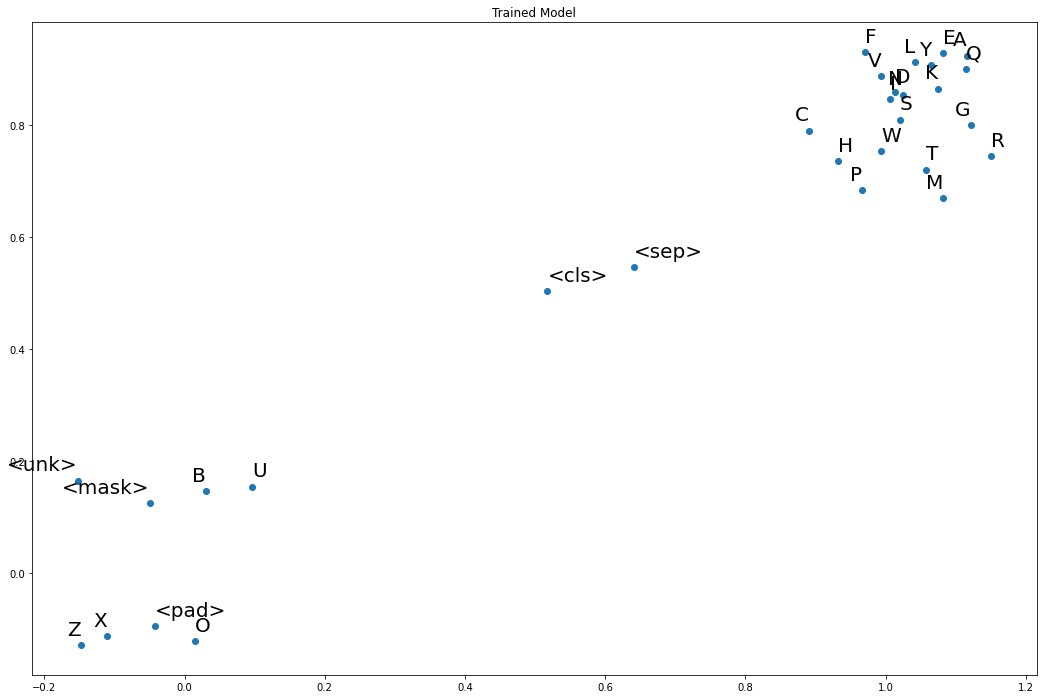

In [15]:
import random
xs = []
ys = []
for i in range(len(outputThree)):
    xs.append(outputThree[i][0])
    ys.append(outputThree[i][1])
print(xs, ys)

docs = list(IUPAC_VOCAB.keys())

plt.clf()
plt.figure(figsize=(18,12))
plt.scatter(xs,ys)
label = docs

for i,(x,y) in enumerate(zip(xs,ys)):
    plt.annotate(label[i], (x,y), textcoords="offset points", xytext=(0,10), fontsize=20, ha = random.choice(['left', 'right']))
    plt.title("Trained Model")
plt.show()

In [30]:
import plotly
import plotly.express as px
from plotly.offline import plot
from IPython.display import display, HTML, IFrame

import plotly.express as px
fig = px.scatter(x=xs, y=ys, text=docs, size_max=100)
fig.update_traces(textposition= random.choice(['top center', 'bottom center','bottom left']))
fig.update_layout(height=600,title_text='Aminoacid Embeddings', width=800)
#fig.show()
plot(fig)
IFrame("temp-plot.html", 800, 600)